# FER sa ResNet152

---------

In [1]:
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

# import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
# import yaml

from os import listdir                  
from os.path import isfile, join

In [2]:
from torchvision.transforms import v2

c:\Users\Nevena\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Nevena\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feed

In [3]:
from sklearn.metrics import classification_report

In [4]:
torch.cuda.is_available()

True

# 1. Training Efficientnet B0 to detect face emotions

## 1.1. Get the data

### Data extraction

In [5]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:
    '''Extracts zipfile'''
    
    if destination_path.is_dir():
        print(f"{destination_path} exists.")
    else:
        print(f"{destination_path} doesn't exist, creating one...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Extracting files...")
            zip.extractall(destination_path)

            print("Extracting finished.")
    else:
        print("Data already extracted.")
    
images_path = Path("upscaled_images")

#extract_data(zipfile_path, images_path)

## Directory exploration
walk_through_dir prints the contents of our dataset

print_random_image prints one randomly chosen image from the whole dataset

In [6]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}' folder ")


walk_through_dir(images_path)

There are 2 directiories and 0 images in 'upscaled_images' folder 
There are 7 directiories and 0 images in 'upscaled_images\test' folder 
There are 0 directiories and 958 images in 'upscaled_images\test\angry' folder 
There are 0 directiories and 1172 images in 'upscaled_images\test\disgusted' folder 
There are 0 directiories and 1024 images in 'upscaled_images\test\fearful' folder 
There are 0 directiories and 1774 images in 'upscaled_images\test\happy' folder 
There are 0 directiories and 1233 images in 'upscaled_images\test\neutral' folder 
There are 0 directiories and 1247 images in 'upscaled_images\test\sad' folder 
There are 0 directiories and 831 images in 'upscaled_images\test\surprised' folder 
There are 7 directiories and 0 images in 'upscaled_images\train' folder 
There are 0 directiories and 3995 images in 'upscaled_images\train\angry' folder 
There are 0 directiories and 3488 images in 'upscaled_images\train\disgusted' folder 
There are 0 directiories and 4097 images in '

## 1.2. Define transforms for train and validation data

In [7]:


train_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()]
)

val_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()]
)

## Visualize tranformations
Print a bunch of transformed images. All the images have been resized to (224x224) and they have 3 color channels.

## 1.3. Prepare the data
Save the data as two datasets that contain photos from train_dir and val_dir with applied transformations.

In [8]:
train_dir = images_path / "train"
val_dir = images_path / "test"

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform
)

## 1.4. Set the dataloaders
To make train data more random set the shuffle to True.
Print the shapes to see if we got the [B, C, H, W] configuration

In [9]:
BATCH_SIZE = 16

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## 1.5. Prepare the model
Define the weights and transforms for the VGG16 model.

Set the device.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Visualize the model
By default all the layers of the model are trainable. Let's freeze the features so model doesn't learn new patterns.

Classifier should stay trainable with output reduces to the amount of classes we predict.

In [11]:
BATCH_SIZE = 16
model = torchvision.models.resnet152(weights = torchvision.models.ResNet152_Weights.DEFAULT).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 1000]           --                   True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [12]:
output_shape = len(train_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2560, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 1000]           17,927               True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     4,096                True
│    │    └─BatchN

## 1.6. Prepare the training
Define training and validation loop

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, train_val_difference=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.train_val_difference = train_val_difference

    def early_stop(self, validation_loss, train_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        elif abs(validation_loss - train_loss) > self.train_val_difference:
            return True
        return False
    
class Checkpointer:
    def __init__(self, model_path):
        self.best_accuracy = 0.0
        self.model_path = model_path

    def check_point(self, val_accuracy, val_loss, epoch, model, optimizer):
        if self.best_accuracy < val_accuracy:
            print("New best accuracy, saving checkpoint...")
            self.best_accuracy = val_accuracy
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, self.model_path)

In [16]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    

    return train_loss, train_acc


def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device) -> Tuple[float, float, torch.Tensor]:

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device) -> Tuple[Dict, torch.Tensor]:

    early_stopper = EarlyStopper(patience=3, min_delta=10, train_val_difference=0.6)
    checkpointer = Checkpointer("resnet152-balanced.pth")

    results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, y_preds = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        checkpointer.check_point(val_acc, val_loss, epoch, model, optimizer)

        if early_stopper.early_stop(val_loss, train_loss):
            print("Stopping early, validation loss not optimal.")             
            break

    return results, y_preds

## Run the model!

In [17]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 30

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.01
)

start_time = timer()

model_results, preds = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

end_time = timer()
print(f"Total learning time: {(end_time - start_time):.3f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.865, Train acc: 0.251, Val loss: 1.827, Val acc: 0.296
New best accuracy, saving checkpoint...
Epoch: 1, Train loss: 1.580, Train acc: 0.393, Val loss: 1.443, Val acc: 0.456
New best accuracy, saving checkpoint...
Epoch: 2, Train loss: 1.379, Train acc: 0.474, Val loss: 1.358, Val acc: 0.490
New best accuracy, saving checkpoint...
Epoch: 3, Train loss: 1.273, Train acc: 0.524, Val loss: 1.345, Val acc: 0.500
New best accuracy, saving checkpoint...
Epoch: 4, Train loss: 1.194, Train acc: 0.548, Val loss: 1.269, Val acc: 0.538
New best accuracy, saving checkpoint...
Epoch: 5, Train loss: 1.129, Train acc: 0.574, Val loss: 1.203, Val acc: 0.564
New best accuracy, saving checkpoint...
Epoch: 6, Train loss: 1.075, Train acc: 0.596, Val loss: 1.211, Val acc: 0.554
Epoch: 7, Train loss: 1.028, Train acc: 0.613, Val loss: 1.164, Val acc: 0.576
New best accuracy, saving checkpoint...
Epoch: 8, Train loss: 0.991, Train acc: 0.627, Val loss: 1.149, Val acc: 0.586
New best 

## 1.7. Visualize the training results.

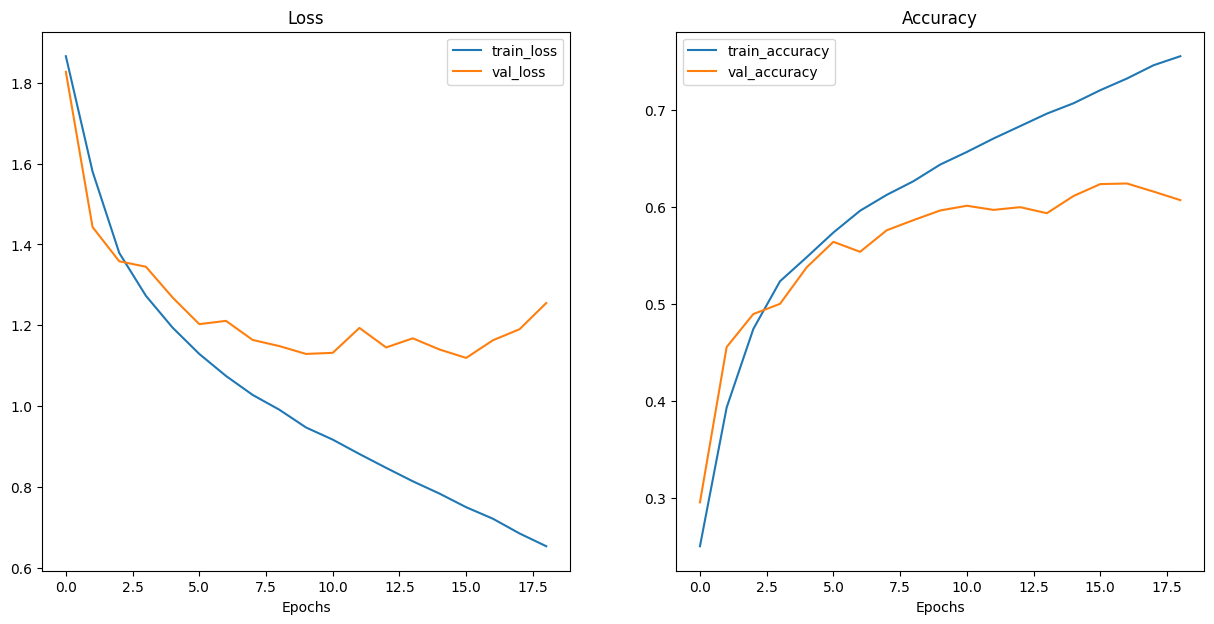

In [18]:
def plot_curves(results: Dict[str, List[float]]) -> None:
    """Plots loss and accuracy from a results dictionary."""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.savefig('graphs/resnet152/loss-accuracy-plot.png')


plot_curves(model_results)

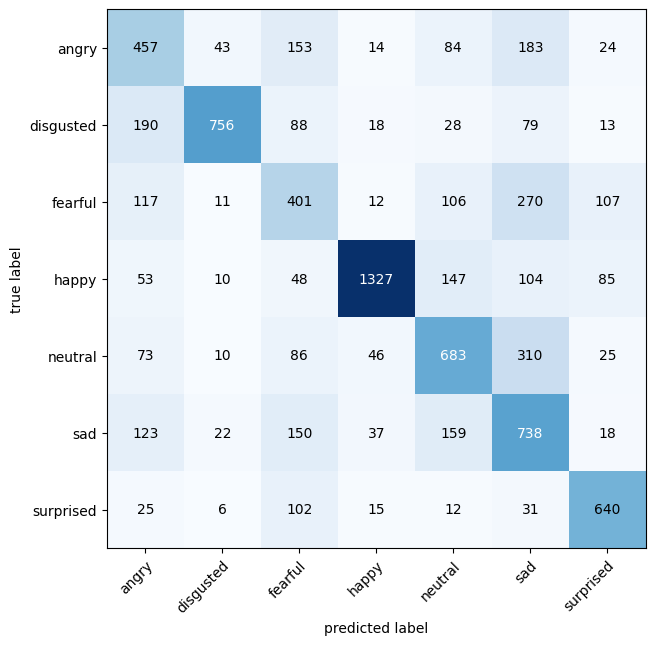

In [19]:
def draw_confusion_matrix(data: datasets.ImageFolder,
                          preds: torch.Tensor) -> None:

    confmat = ConfusionMatrix(num_classes=len(data.classes),task='multiclass')
    confmat_tensor = confmat(
        preds=preds,
        target=torch.ShortTensor(val_data.targets)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=data.classes,
        figsize=(10, 7))
    fig.savefig('graphs/resnet152/confusion-matrix.png')


draw_confusion_matrix(data=val_data,
                      preds=preds)

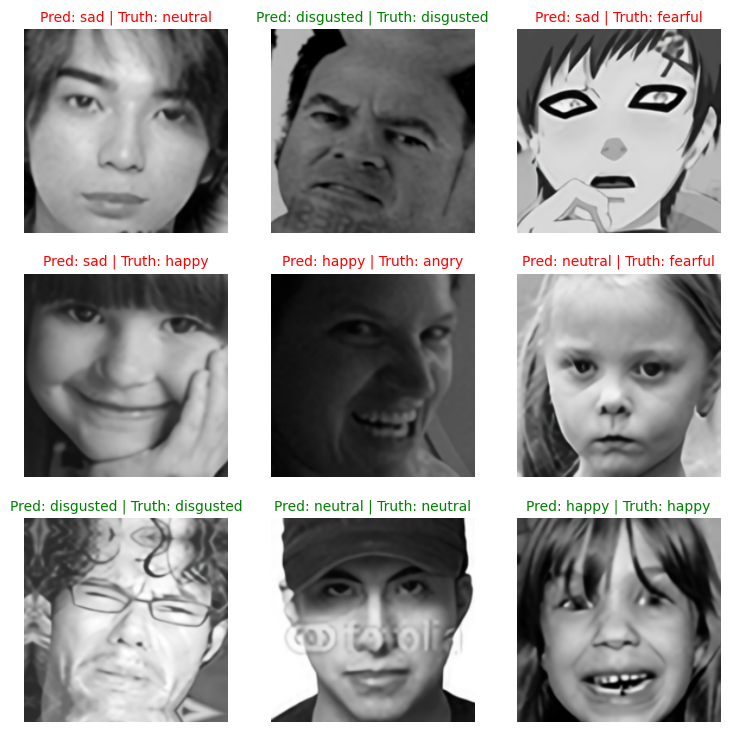

In [20]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:

    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


def show_predictions(model: torch.nn.Module,
                     device: torch.device,
                     val_data: datasets) -> None:

    val_samples = []
    val_labels = []

    for sample, label in random.sample(list(val_data), k=9):
        val_samples.append(sample)
        val_labels.append(label)

    pred_probs = make_predictions(
        model=model,
        data=val_samples,
        device=device
    )

    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3

    for i, sample in enumerate(val_samples):
        plt.subplot(nrows, ncols, i+1)
        image = sample.squeeze().permute(1, 2, 0)
        plt.imshow(image)
        pred_label = val_data.classes[pred_classes[i]]
        truth_label = val_data.classes[val_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")
        else:
            plt.title(title_text, fontsize=10, c="r")
        plt.axis(False)


show_predictions(
    model=model,
    val_data=val_data,
    device=device)

In [21]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

In [22]:
torch.save(model, 'resnet152-balanced-final.pth')

In [23]:
model = torch.load('resnet152-balanced-final.pth', weights_only=False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 